# Anything related to the z coordinate data

## Save out regridded historical depth data (for section plot only)

This whole thing is repeated quite often, that should be a utility (after I factor out the general parts to cmip6_pp)

In [1]:
# %load_ext autoreload
# %autoreload 2

In [4]:
import xarray as xr
test = xr.open_dataset('../../data/processed/z_omz_vol_trends/CMIP_MRI_MRI-ESM2-0_historical_Omon_gn_none_r1i2p1f1.nc')
test

<xarray.Dataset>
Dimensions:    (lev: 61, o2_bin: 9)
Coordinates:
    dz_t       (lev) float64 ...
  * lev        (lev) float64 1.0 3.5 6.5 10.0 ... 5.5e+03 6.15e+03 6.525e+03
  * o2_bin     (o2_bin) int64 5 10 20 40 60 80 100 120 140
Data variables:
    slope      (o2_bin, lev) float64 ...
    intercept  (o2_bin, lev) float64 ...
    r_value    (o2_bin, lev) float64 ...
    p_value    (o2_bin, lev) float64 ...
    std_err    (o2_bin, lev) float64 ...
Attributes:
    Conventions:             CF-1.7 CMIP-6.2
    activity_id:             CMIP
    branch_method:           standard
    cmor_version:            3.5.0
    creation_date:           2019-10-29T01:25:11Z
    data_specs_version:      01.00.31
    experiment:              all-forcing simulation of the recent past
    experiment_id:           historical
    external_variables:      areacello volcello
    forcing_index:           1
    frequency:               mon
    further_info_url:        https://furtherinfo.es-doc.org/CMIP6.MRI.MRI-ESM...
    grid:                    native ocean tri-polar grid with 360x363 ocean c...
    grid_label:              gn
    history:                 2019-10-29T01:25:11Z ; CMOR rewrote data to be c...
    initialization_index:    2
    institution:             Meteorological Research Institute, Tsukuba, Ibar...
    institution_id:          MRI
    intake_esm_dataset_key:  CMIP.MRI.MRI-ESM2-0.historical.r1i2p1f1.Omon.o2....
    license:                 CMIP6 model data produced by MRI is licensed und...
    mip_era:                 CMIP6
    nominal_resolution:      100 km
    parent_activity_id:      CMIP
    parent_experiment_id:    piControl
    parent_mip_era:          CMIP6
    parent_source_id:        MRI-ESM2-0
    physics_index:           1
    product:                 model-output
    realization_index:       1
    realm:                   ocnBgchem
    source:                  MRI-ESM2.0 (2017): \naerosol: MASINGAR mk2r4 (TL...
    source_id:               MRI-ESM2-0
    source_type:             AOGCM BGC AER CHEM
    sub_experiment:          none
    sub_experiment_id:       none
    table_id:                Omon
    table_info:              Creation Date:(24 July 2019) MD5:c93735846d66458...
    title:                   MRI-ESM2-0 output prepared for CMIP6
    tracking_id:             hdl:21.14100/e179b671-ac54-4663-a31c-4f11b03d12cf
    variable_id:             o2
    variant_label:           r1i2p1f1

In [5]:
import numpy as np
import xarray as xr
import warnings
import dask
import intake
import pathlib
import shutil
from dask.diagnostics import ProgressBar
import matplotlib.pyplot as plt
from xarrayutils.file_handling import maybe_create_folder, write, temp_write_split
from xarrayutils.utils import linear_trend
from fastprogress.fastprogress import progress_bar


from aguadv_omz_busecke_2021.cmip6_stash import (
    load_single_datasets,
    nested_dataset_wrapper,
    match_and_detrend,
    combine_grid_labels,
    parse_metrics,
    cmip6_dataset_id
)
from aguadv_omz_busecke_2021.utils import cmip6_collection
from aguadv_omz_busecke_2021.omz_tools import omz_thickness, region
from aguadv_omz_busecke_2021.cmip6_stash import load_trend_dict

col = intake.open_esm_datastore(cmip6_collection(zarr=True))

In [6]:
%matplotlib inline

In [7]:
dask.config.set(**{'array.slicing.split_large_chunks': False})

In [8]:
historical_time = slice('1960', '2000')

In [6]:
ddict = load_single_datasets(
    col,
    source_id=[
#         "UKESM1-0-LL", 
#         "MRI-ESM2-0", 
#         "NorESM2-LM",
#         "NorESM2-MM",
#         "GFDL-ESM4",
        "GFDL-CM4",
#         "MIROC-ES2L", 
#         "CNRM-ESM2-1", 
#         "CanESM5", 
#         "CanESM5-CanOE",
#         "MPI-ESM1-2-HR",
#         "ACCESS-ESM1-5",
#         "IPSL-CM6A-LR",
#         "MPI-ESM1-2-LR",
    ],
    grid_label=["gr", "gn"],
    experiment_id=["historical"],
    table_id=["Omon"],
    variable_id=["thetao", "so", "o2"],
)

Dataframe size before picking latest version: 5
Getting latest version...

Dataframe size after picking latest version: 5

Done....


--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.member_id.table_id.variable_id.grid_label.version.zstore'


In [7]:
ddict = {k:ds.chunk({'time':1, 'lev':1}) for k,ds in ddict.items()}

In [8]:
# Load all trends into dict
trendfolder = pathlib.Path('../../data/processed/linear_regression_time_zarr_multimember/')
trend_dict = load_trend_dict(trendfolder, ddict)

# trend_models = np.unique([ds.attrs['source_id'] for ds in ddict.values()])
# flist = []
# for tm in trend_models:
#     flist = flist + list(trendfolder.glob(f'*{tm}*_trend.nc'))

# total = len(flist)
# progress = progress_bar(range(total))

# trend_dict = {}
# for i,path in enumerate(flist):
#     key = path.stem
#     ds = xr.open_mfdataset([path])
#     # write the filename in the dataset
#     ds.attrs.update({'filepath':str(path)})
#     # exclude all nan slopes (why are these there in the first place?)
#     if not np.isnan(ds.slope).all():
#         trend_dict[key] = ds
#     else:
#         print(f"found all nan regression data for {path}")
#     progress.update(i)
# progress.update(total)

In [9]:
ddict_detrended = match_and_detrend(
    ddict,
    trend_dict,
    verbose=True,
    pass_variables=["areacello", "thkcello", "mlotst"],
)

In [10]:
ddict_detrended_filtered = {k:v for k,v in ddict_detrended.items() if 'rho' not in v.dims}

In [11]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    ddict_nested_z = nested_dataset_wrapper(ddict_detrended_filtered, verbose=False)

using dimensions ('y', 'x') from data variable o2 as the horizontal dimensions for this dataset.


In [12]:
def parse_member_id(name, ds):
    member_id = name.split('.')[-2]
    if 'member_id' not in ds.dims:
        print(f"no member id in dims for {name}")
    else:
        print(f"Found {ds.member_id.data} for {name}")
        
    ds = ds.assign_coords(member_id=xr.DataArray([member_id], dims=['member_id']))
    return ds

ddict_nested_z = {k:parse_member_id(k,ds) for k, ds in ddict_nested_z.items()}

Found [0] for CMIP.NOAA-GFDL.GFDL-CM4.historical.r1i1p1f1.Omon


In [13]:
len(np.unique(['.'.join(s.split('.')[2:3]) for s in list(ddict_nested_z)]))

1

In [14]:
ddict_nested_z['CMIP.NOAA-GFDL.GFDL-CM4.historical.r1i1p1f1.Omon']

<xarray.Dataset>
Dimensions:                (bnds: 2, lev: 35, member_id: 1, time: 1980, vertex: 4, x: 1440, y: 1080)
Coordinates:
  * bnds                   (bnds) int64 0 1
  * x                      (x) float64 -299.7 -299.5 -299.2 ... 59.78 60.03
  * y                      (y) float64 -80.39 -80.31 -80.23 ... 89.84 89.95
  * lev                    (lev) float64 2.5 10.0 20.0 ... 5.5e+03 6e+03 6.5e+03
  * time                   (time) object 1850-01-16 12:00:00 ... 2014-12-16 1...
  * vertex                 (vertex) int64 0 1 2 3
    lon                    (y, x) float32 60.28 60.53 60.78 ... 60.0 60.0 60.0
    lat                    (y, x) float32 -79.81 -79.81 -79.8 ... 64.22 64.11
    lat_verticies          (y, x, vertex) float32 dask.array<chunksize=(1080, 1440, 4), meta=np.ndarray>
    lev_bounds             (lev, bnds) float64 dask.array<chunksize=(1, 2), meta=np.ndarray>
    lon_verticies          (y, x, vertex) float32 dask.array<chunksize=(1080, 1440, 4), meta=np.ndarray>
    time_bounds            (time, bnds) object dask.array<chunksize=(1, 2), meta=np.ndarray>
    lon_bounds             (bnds, y, x) float32 dask.array<chunksize=(1, 1080, 1440), meta=np.ndarray>
    lat_bounds             (bnds, y, x) float32 dask.array<chunksize=(1, 1080, 1440), meta=np.ndarray>
    branch_time_in_parent  (member_id) int64 dask.array<chunksize=(1,), meta=np.ndarray>
    branch_time_in_child   (member_id) float64 dask.array<chunksize=(1,), meta=np.ndarray>
    parent_time_units      (member_id) <U19 dask.array<chunksize=(1,), meta=np.ndarray>
    child_time_units       (member_id) <U38 dask.array<chunksize=(1,), meta=np.ndarray>
    parent_variant_label   (member_id) <U8 dask.array<chunksize=(1,), meta=np.ndarray>
  * member_id              (member_id) <U8 'r1i1p1f1'
Data variables:
    o2                     (lev, time, y, x) float64 dask.array<chunksize=(1, 1, 1080, 1440), meta=np.ndarray>
    so                     (time, lev, y, x) float64 dask.array<chunksize=(1, 1, 1080, 1440), meta=np.ndarray>
    thetao                 (time, lev, y, x) float64 dask.array<chunksize=(1, 1, 1080, 1440), meta=np.ndarray>
Attributes:
    regrid_method:                           bilinear
    Conventions:                             CF-1.7 CMIP-6.0 UGRID-1.0
    activity_id:                             CMIP
    branch_method:                           standard
    comment:                                 <null ref>
    contact:                                 gfdl.climate.model.info@noaa.gov
    creation_date:                           2019-02-24T04:16:12Z
    data_specs_version:                      01.00.27
    experiment:                              historical
    experiment_id:                           historical
    external_variables:                      areacello volcello
    forcing_index:                           [1]
    frequency:                               mon
    further_info_url:                        https://furtherinfo.es-doc.org/C...
    grid:                                    ocean data on native grid tripol...
    grid_label:                              gn
    history:                                 File was processed by fremetar (...
    initialization_index:                    [1]
    institution:                             National Oceanic and Atmospheric...
    institution_id:                          NOAA-GFDL
    license:                                 CMIP6 model data produced by NOA...
    mip_era:                                 CMIP6
    nominal_resolution:                      25 km
    parent_activity_id:                      CMIP
    parent_experiment_id:                    piControl
    parent_mip_era:                          CMIP6
    parent_source_id:                        GFDL-CM4
    physics_index:                           [1]
    product:                                 model-output
    realization_index:                       [1]
    realm:                                   ocean
    referen

## Average historical values

In [18]:
ofolder = maybe_create_folder("../../data/processed/historical_mean_z")
tempfolder = maybe_create_folder("../../data/temp/preprocessing_z_data/")
for name, ds in progress_bar(ddict_nested_z.items()):
    attrs = {k:v for k,v in ds.attrs.items() if k not in ['intake_esm_varname']}
    if 'o2' in ds.data_vars:
        ds_hist = ds.sel(time=historical_time)
        ds_hist.attrs['intake_esm_varname'] = 'none'
        for va in ds_hist.variables:
            if 'chunks' in ds_hist[va].encoding.keys():
                del ds_hist[va].encoding['chunks']
                
        temp_flist = []
        if ds_hist.attrs['source_id'] in ['GFDL-CM4']:
            ds_hist, tempfilelist = temp_write_split(ds_hist, tempfolder, split_interval=36)

        ds_hist = ds_hist.mean("time")
        ds_hist.attrs = attrs
        ds_hist.attrs[
            "averaging_period"
        ] = f"{str(historical_time.start)}-{str(historical_time.stop)}"
        dataset_id = f"{cmip6_dataset_id(ds)}_{ds.attrs['variant_label']}"
        filename = ofolder.joinpath(f"{dataset_id}.nc")
        with ProgressBar():
            ds_hist_reloaded = write(
                ds_hist,
                filename,
                overwrite=True,
            )
        plt.figure()
        ds_hist_reloaded.isel(x=len(ds_hist_reloaded.x)//2).o2.plot(robust=True)
        plt.show()
        for tf in tempfilelist:
            if tf.exists():
                shutil.rmtree(tf)

/scratch/gpfs/jbusecke/conda_tigercpu/envs/aguadv_omz_busecke_2021/lib/python3.8/site-packages/xarrayutils/file_handling.py:118: UserWarning: Folder ../../data/processed/historical_mean_z does already exist.
  warnings.warn(f"Folder {path} does already exist.", UserWarning)
/scratch/gpfs/jbusecke/conda_tigercpu/envs/aguadv_omz_busecke_2021/lib/python3.8/site-packages/xarrayutils/file_handling.py:118: UserWarning: Folder ../../data/temp/preprocessing_z_data/ does already exist.
  warnings.warn(f"Folder {path} does already exist.", UserWarning)


AttributeError: 'tuple' object has no attribute 'mean'

## Trends for 2000-2100

In [9]:
ddict = load_single_datasets(
    col,
    source_id=[
        "UKESM1-0-LL", 
        "MRI-ESM2-0", 
        "NorESM2-LM",
        "NorESM2-MM",
        "GFDL-ESM4",
        "GFDL-CM4",
        "MIROC-ES2L", 
        "CNRM-ESM2-1", 
        "CanESM5", 
        "CanESM5-CanOE",
        "MPI-ESM1-2-HR",
        "ACCESS-ESM1-5",
        "IPSL-CM6A-LR",
        "MPI-ESM1-2-LR",
    ],
    grid_label=["gr", "gn"],
    experiment_id=["historical", 'ssp585'],
    table_id=["Omon", "Ofx"],
    variable_id=["o2", "thkcello", "areacello"],
)

Dataframe size before picking latest version: 735
Getting latest version...

Dataframe size after picking latest version: 734

Done....


--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.member_id.table_id.variable_id.grid_label.version.zstore'


MIROC-ES2L: No units found
MIROC-ES2L: No units found
MIROC-ES2L: No units found
MIROC-ES2L: No units found
MIROC-ES2L: No units found
MIROC-ES2L: No units found
MIROC-ES2L: No units found
MIROC-ES2L: No units found
MIROC-ES2L: No units found
MIROC-ES2L: No units found
MIROC-ES2L: No units found


In [10]:
# ddict = {k:ds.chunk({k:v for k,v in {'time':1, 'lev':1}.items() if k in ds.dims}) for k,ds in ddict.items()}

In [11]:
ddict = {
    k: v for k, v in ddict.items() if "rho" not in v.dims
}

In [12]:
trendfolder = pathlib.Path('../../data/processed/linear_regression_time_zarr_multimember/')
trend_dict = load_trend_dict(trendfolder, ddict)

In [13]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    ddict_detrended = match_and_detrend(
        ddict,
        trend_dict,
        verbose=True,
        pass_variables=["areacello", "thkcello", "mlotst"],
    )

    ddict_nested = nested_dataset_wrapper(ddict_detrended)
    
    ddict_nested_metrics = parse_metrics(ddict_nested)

Manually Ingnored Variable: Passing ScenarioMIP.MPI-M.MPI-ESM1-2-LR.ssp585.r8i1p1f1.Ofx.areacello.gn unaltered
Manually Ingnored Variable: Passing CMIP.MPI-M.MPI-ESM1-2-LR.historical.r3i1p1f1.Ofx.areacello.gn unaltered
Manually Ingnored Variable: Passing CMIP.CCCma.CanESM5.historical.r17i1p1f1.Ofx.areacello.gn unaltered
Manually Ingnored Variable: Passing CMIP.CCCma.CanESM5.historical.r10i1p1f1.Ofx.areacello.gn unaltered
Manually Ingnored Variable: Passing CMIP.CCCma.CanESM5.historical.r6i1p2f1.Ofx.areacello.gn unaltered
Manually Ingnored Variable: Passing CMIP.CCCma.CanESM5.historical.r4i1p1f1.Ofx.areacello.gn unaltered
Manually Ingnored Variable: Passing CMIP.CCCma.CanESM5.historical.r5i1p1f1.Ofx.areacello.gn unaltered
Manually Ingnored Variable: Passing CMIP.CCCma.CanESM5.historical.r1i1p1f1.Ofx.areacello.gn unaltered
Manually Ingnored Variable: Passing ScenarioMIP.CCCma.CanESM5.ssp585.r6i1p1f1.Ofx.thkcello.gn unaltered
Manually Ingnored Variable: Passing CMIP.CCCma.CanESM5.historic

In [14]:
# # merge source_ids and also concat experiment_ids? This might revive the problem with the large chunks
# source_ids = np.unique([ds.attrs['source_id'] for ds in ddict.values()])# this should work but some do not have the correct attributes (might want to parse them, 
# # because I am sure as hell not going to reprocess these for that)
# # alternative approach based on keys
source_ids = np.unique([k.split('.')[2] for k in ddict_nested_metrics.keys()])
member_ids = np.unique([k.split('.')[-1] for k in ddict_nested_metrics.keys()])

sep = '.'
ddict_merged = {}
for si in source_ids:
    ddict_sub = {k:v for k,v in ddict_nested_metrics.items() if f"{sep}{si}{sep}" in k}
#     print(ddict_sub)
    if len(ddict_sub)>0:
        ddict_merged[si] = {}
        for mi in member_ids:
            ddict_sub_sub = {k:v for k,v in ddict_sub.items() if f"{sep}{mi}" in k}
            if len(ddict_sub_sub)>0:
                datasets = ddict_sub_sub.values()
                data_vars = np.unique(sum([list(ds.data_vars) for ds in datasets], start=[]))
                datasets = [ds for ds in datasets if all([va in ds.data_vars for va in data_vars])]
                # only combine if there are two runs...(historical +  ssp585)
                if len(datasets)==2:
                    ds = xr.concat(datasets, dim='time', compat='override', join='outer', coords='minimal')
                else:
                    ds = None
                if ds is not None:
                    # one more check:
                    if np.isnan(ds.o2.isel(time=slice(0,24))).any(): #filter out the all nan members?
                        print(f'Processing {si}/{mi}')
                        ddict_merged[si][mi] = ds

Processing ACCESS-ESM1-5/r1i1p1f1
Processing ACCESS-ESM1-5/r2i1p1f1
Processing ACCESS-ESM1-5/r3i1p1f1
Processing CNRM-ESM2-1/r1i1p1f2
Processing CNRM-ESM2-1/r2i1p1f2
Processing CNRM-ESM2-1/r3i1p1f2
Processing CNRM-ESM2-1/r4i1p1f2
Processing CNRM-ESM2-1/r5i1p1f2
Processing CanESM5/r10i1p1f1
Processing CanESM5/r10i1p2f1
Processing CanESM5/r1i1p1f1
Processing CanESM5/r1i1p2f1
Processing CanESM5/r2i1p1f1
Processing CanESM5/r2i1p2f1
Processing CanESM5/r3i1p1f1
Processing CanESM5/r3i1p2f1
Processing CanESM5/r4i1p1f1
Processing CanESM5/r4i1p2f1
Processing CanESM5/r5i1p1f1
Processing CanESM5/r5i1p2f1
Processing CanESM5/r6i1p1f1
Processing CanESM5/r6i1p2f1
Processing CanESM5/r7i1p1f1
Processing CanESM5/r7i1p2f1
Processing CanESM5/r8i1p1f1
Processing CanESM5/r8i1p2f1
Processing CanESM5/r9i1p1f1
Processing CanESM5/r9i1p2f1
Processing CanESM5-CanOE/r1i1p2f1
Processing CanESM5-CanOE/r2i1p2f1
Processing CanESM5-CanOE/r3i1p2f1
Processing GFDL-CM4/r1i1p1f1
Processing GFDL-ESM4/r1i1p1f1
Processing IPSL

In [15]:
from aguadv_omz_busecke_2021.rechunker_tools import rechunk_to_temp
from aguadv_omz_busecke_2021.utils import print_html

/scratch/gpfs/jbusecke/conda_tigercpu/envs/aguadv_omz_busecke_2021/lib/python3.8/site-packages/xarrayutils/file_handling.py:118: UserWarning: Folder ../../data/processed/z_omz_vol_trends does already exist.
  warnings.warn(f"Folder {path} does already exist.", UserWarning)
/scratch/gpfs/jbusecke/conda_tigercpu/envs/aguadv_omz_busecke_2021/lib/python3.8/site-packages/xarrayutils/file_handling.py:118: UserWarning: Folder ../../data/temp/preprocessing_z_data/trends does already exist.
  warnings.warn(f"Folder {path} does already exist.", UserWarning)


ACCESS-ESM1-5 r1i1p1f1
Plotting


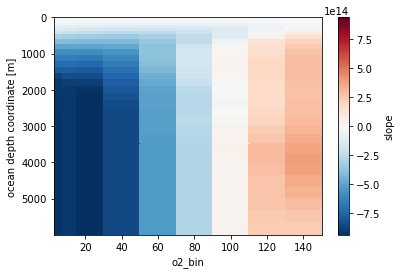

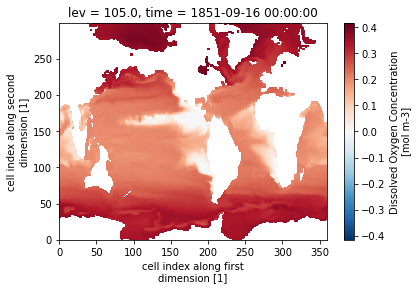

CNRM-ESM2-1 r1i1p1f2
Plotting


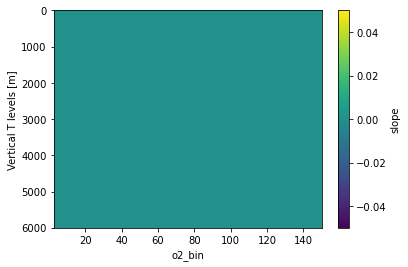

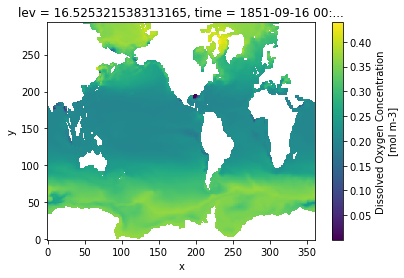

CNRM-ESM2-1 r2i1p1f2
Plotting


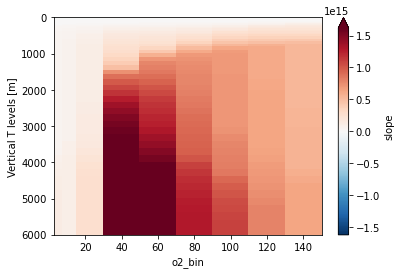

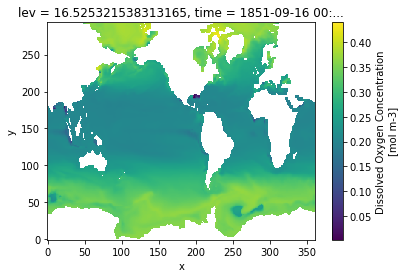

CanESM5 r10i1p1f1
Plotting


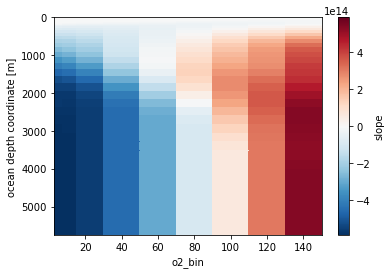

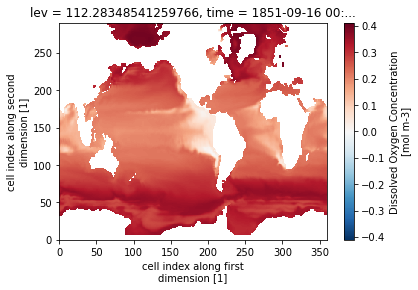

CanESM5-CanOE r1i1p2f1
Plotting


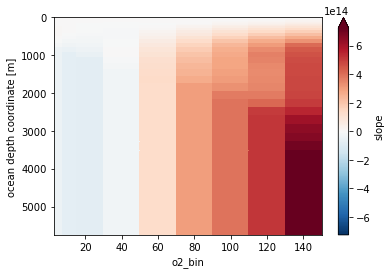

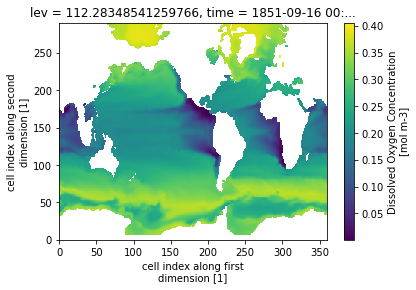

GFDL-CM4 r1i1p1f1
Plotting


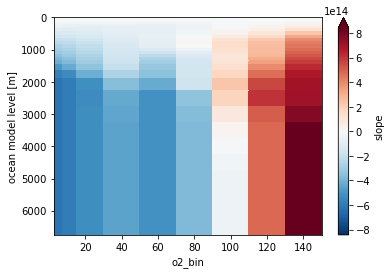

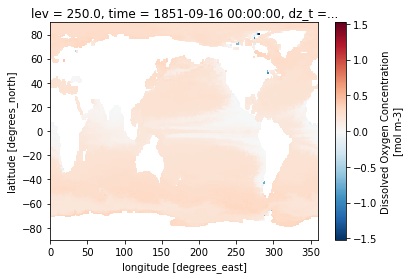

GFDL-ESM4 r1i1p1f1
Plotting


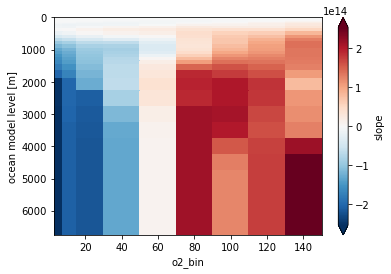

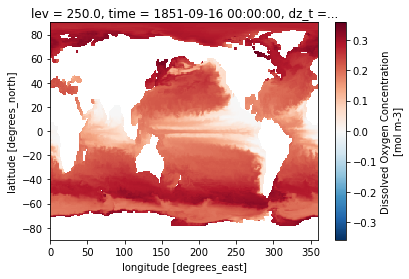

IPSL-CM6A-LR r14i1p1f1
Plotting


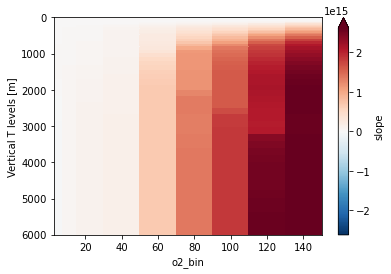

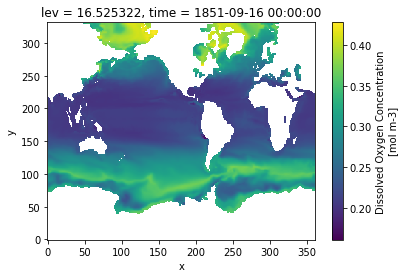

MIROC-ES2L r1i1p1f2
Plotting


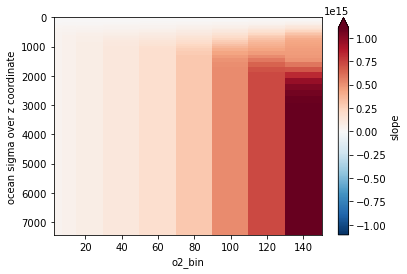

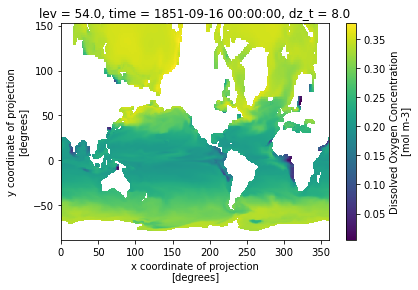

MPI-ESM1-2-HR r1i1p1f1


write temp file


rechunk
Rechunking to: {'areacello': (404, 802), 'bnds': (2,), 'branch_time_in_child': (1,), 'branch_time_in_parent': (1,), 'child_time_units': (1,), 'dx_gx': (404, 802), 'dx_gxgy': (404, 802), 'dx_gy': (404, 802), 'dx_t': (404, 802), 'dy_gx': (404, 802), 'dy_gxgy': (404, 802), 'dy_gy': (404, 802), 'dy_t': (404, 802), 'dz_t': (404, 802, 1, 60), 'lat': (404, 802), 'lat_bounds': (404, 802, 2), 'lat_verticies': (404, 802, 4), 'lev': (1,), 'lev_bounds': (2, 1), 'lon': (404, 802), 'lon_bounds': (404, 802, 2), 'lon_verticies': (404, 802, 4), 'o2': (404, 802, 1, 60), 'parent_time_units': (1,), 'parent_variant_label': (1,), 'time': (60,), 'time_bounds': (2, 60), 'vertex': (4,), 'x': (802,), 'x_right': (802,), 'y': (404,), 'y_left': (404,)}
[########################################] | 100% Completed |  0.4s
[########################################] | 100% Completed |  0.4s
[########################################] | 100% Completed |  4min 44.5s
removing temp store
done
reloading
Select Region

calculate the thickness


Regress


$ Saving 1.4792e-05GB to ../../data/processed/z_omz_vol_trends/CMIP_MPI-M_MPI-ESM1-2-HR_historical_Omon_gn_none_r1i1p1f1.nc
[########################################] | 100% Completed |  2min 39.5s
$ Reloading file
Plotting


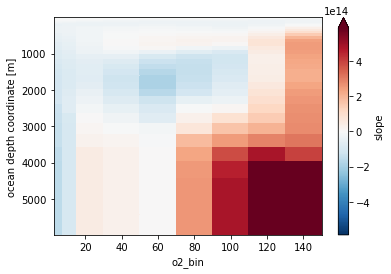

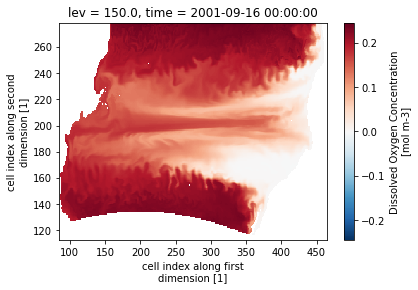

MPI-ESM1-2-LR r10i1p1f1
Plotting


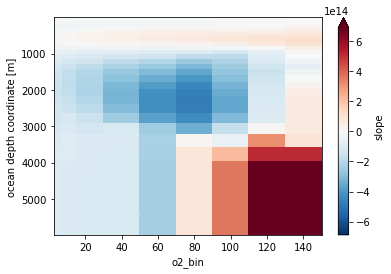

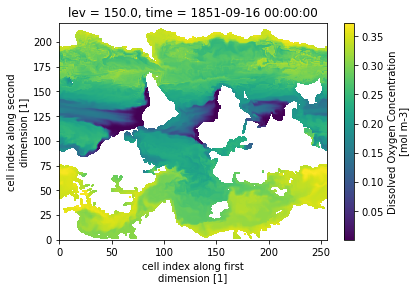

MRI-ESM2-0 r1i2p1f1
Plotting


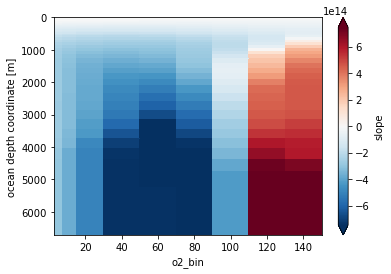

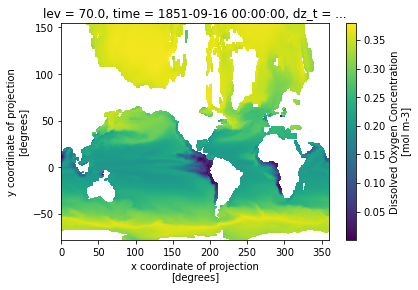

NorESM2-LM r1i1p1f1
Plotting


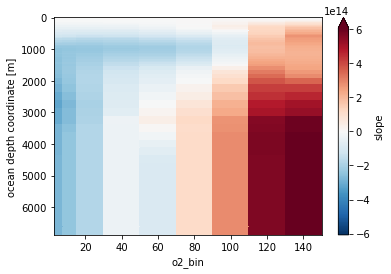

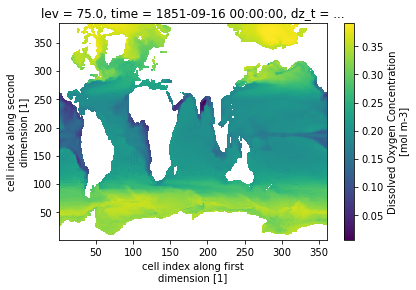

NorESM2-MM r1i1p1f1
Plotting


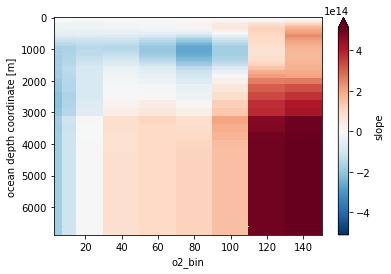

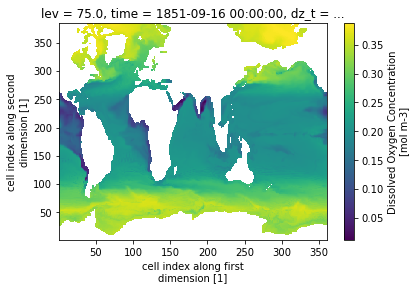

UKESM1-0-LL r1i1p1f2
Plotting


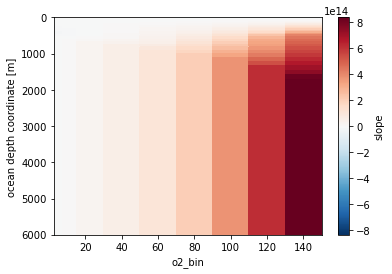

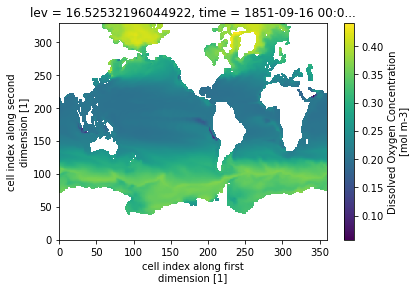

In [18]:
ofolder = maybe_create_folder("../../data/processed/z_omz_vol_trends")
tempfolder = maybe_create_folder("../../data/temp/preprocessing_z_data/trends")

for source_id in ddict_merged.keys():
    #     for source_id in ['MIROC-ES2L', 'MPI-ESM1-2-LR']:
    trigger = 1
    for member_id in ddict_merged[source_id].keys():
        if trigger:
            print(f"{source_id} {member_id}")

            ds = ddict_merged[source_id][member_id]

            ds.attrs["intake_esm_varname"] = "none"

            for va in ds.variables:
                
#                 if "chunks" in ds[va].encoding.keys():
#                     del ds[va].encoding["chunks"]
                ds[va].encoding = {}
            ds.encoding={}

            filename = ofolder.joinpath(f"{cmip6_dataset_id(ds)}_{member_id}.nc")

            if filename.exists():
                reg_reloaded = xr.open_dataset(filename)
                if (reg_reloaded.slope > 0).any():
                    trigger = 0
                else:
                    trigger = 1  # keep going if the reg is all zero...
            else:

                ds = ds.sel(time=slice("2000", "2100"))
                assert len(ds.time) > 1200
                
                print_html(ds)
                
                print("write temp file")
                ds = ds.chunk({"time": 3})
                ds, tempfilelist0 = temp_write_split(ds, tempfolder, split_interval=24)
                
                print_html(ds)
                
                print("rechunk")
                chunks = {"time": 60, "lev": 1, "x": 1440, "y": 1080}
                with ProgressBar():
                    ds = rechunk_to_temp(
                        ds,
                        tempfolder.joinpath('temp_rechunker.zarr'),
                        store_temp=tempfolder.joinpath('temp_temp_rechunker.zarr'),
                        chunks=chunks,
                        consolidated=False,
                        mem="1500 MB",
                    )
                
                print('Select Region')
                with ProgressBar():
                    ds = region(ds)
                
                print_html(ds)

                print("calculate the thickness")
                with ProgressBar():
                    ds["omz_thickness"] = omz_thickness(ds)
#                 lon = ds.lon
#                 lat = ds.lat
#                 area = ds.areacello
#                 ds = ds.reset_coords(drop=True)
#                 ds = ds.assign_coords(lon=lon, lat=lat, areacello=area)
                
#                 print("write temp file")
#                 ds, tempfilelist1 = temp_write_split(ds.chunk(chunks), tempfolder.joinpath('again'), split_interval=60)
                ds["omz_volume"] = (ds["omz_thickness"] * ds.areacello).sum(["x", "y"])
                
        
                print_html(ds)
                print("Regress")
                with ProgressBar():
                    reg = linear_trend(ds.omz_volume, "time")
                reg.attrs.update(
                    {
                        k: v
                        for k, v in ds.attrs.items()
                        if k not in ["intake_esm_varname"]
                    }
                )
                
                print_html(reg)

                with ProgressBar():
                    reg_reloaded = write(
                        reg,
                        filename,
                        overwrite=False,
                        check_zarr_consolidated_complete=True,
                    )
                if (reg_reloaded.slope > 0).any():
                    trigger = 0
                else:
                    trigger = 1  # keep going if the reg is all zero...

                for tf in tempfilelist0:
                    if tf.exists():
                        shutil.rmtree(tf)

            print("Plotting")
            (reg_reloaded.slope * 100).cumsum("lev").plot(
                robust=True, y="lev", yincrease=False
            )
            plt.figure()
            ds.o2.isel(lev=10, time=20).plot()
            plt.show()

## Regrid the z data in depth and horizontally

In [6]:
from fastjmd95 import rho
from euc_dynamics.cmip6_preprocessing_stash import regrid_horizontal
from xarrayutils.file_handling import write

In [7]:
n_kwargs = {'use_cftime':True}

In [8]:
# Trend output
dfolder = pathlib.Path('../../data/processed/historical_mean_z/')
flist = list(dfolder.glob('*.nc'))
ddict_z_hist = {f.stem:xr.open_mfdataset([f], **n_kwargs) for f in flist}

In [10]:
# average members
source_ids = np.unique([ds.attrs['source_id'] for ds in ddict_z_hist.values()])
ddict_z_hist_member_mean = {}
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    for model in progress_bar(source_ids):
        datasets = [ds for k,ds in ddict_z_hist.items() if model in k and 'thetao' in ds.data_vars]
        ds = xr.concat(datasets, dim='member_id').mean('member_id')
        ds = ds.assign_coords({va:datasets[0][va] for va in ['lon','lat']})
        ddict_z_hist_member_mean[model] = ds

# get levels from one of the high vertical res models
lev_new = ddict_z_hist_member_mean[
    "IPSL-CM6A-LR"
].lev.data

ddict_z_hist_interpolated = {
    k: ds.interp(lev=lev_new) for k, ds in ddict_z_hist_member_mean.items()
}

datasets = []
models = []
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    for k, ds in progress_bar(ddict_z_hist_interpolated.items()):
        ds_regridded = regrid_horizontal(
            ds.drop(
                [va for va in ["lon_verticies", "lat_verticies"] if va in ds.variables]
            ),
            0.25,
            0.25,
            ignore_degenerate=True,
        )
        ds_regridded = ds_regridded.assign_coords(model=k)
        datasets.append(ds_regridded)
        models.append(k)

In [11]:
full_z = xr.concat(datasets, dim='model')
full_z['sigma_0'] = rho(full_z.so, full_z.thetao, 0) - 1000
pacific_z = region(full_z)
pacific_z

,Array,Chunk
Bytes,1.41 GB,317.40 kB
Shape,"(14, 75, 240, 698)","(1, 75, 23, 23)"
Count,33263 Tasks,4928 Chunks
Type,float64,numpy.ndarray
,Array,Chunk
Bytes,1.41 GB,317.40 kB
Shape,"(14, 75, 240, 698)","(1, 75, 23, 23)"
Count,34015 Tasks,4928 Chunks
Type,float64,numpy.ndarray
,Array,Chunk


In [13]:
ofolder = maybe_create_folder("../../data/processed/historical_mean_z_combined")
filename = ofolder.joinpath('pacific_z_combined.nc')
with ProgressBar():
    pacific_z_reloaded = write(pacific_z, filename, overwrite=True)

/scratch/gpfs/jbusecke/conda_tigercpu/envs/aguadv_omz_busecke_2021/lib/python3.8/site-packages/xarrayutils/file_handling.py:118: UserWarning: Folder ../../data/processed/historical_mean_z_combined does already exist.
  warnings.warn(f"Folder {path} does already exist.", UserWarning)


Removing file ../../data/processed/historical_mean_z_combined/pacific_z_combined.nc
$ Saving 5.647442204GB to ../../data/processed/historical_mean_z_combined/pacific_z_combined.nc
[                                        ] | 0% Completed |  8.8s

/scratch/gpfs/jbusecke/conda_tigercpu/envs/aguadv_omz_busecke_2021/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[###########                             ] | 27% Completed |  3min 48.1s

/scratch/gpfs/jbusecke/conda_tigercpu/envs/aguadv_omz_busecke_2021/lib/python3.8/site-packages/fastjmd95/jmd95wrapper.py:39: RuntimeWarning: invalid value encountered in rho
  return jmd95numba.rho(s,t,p)


[########################################] | 100% Completed | 18min 16.9s
$ Reloading file


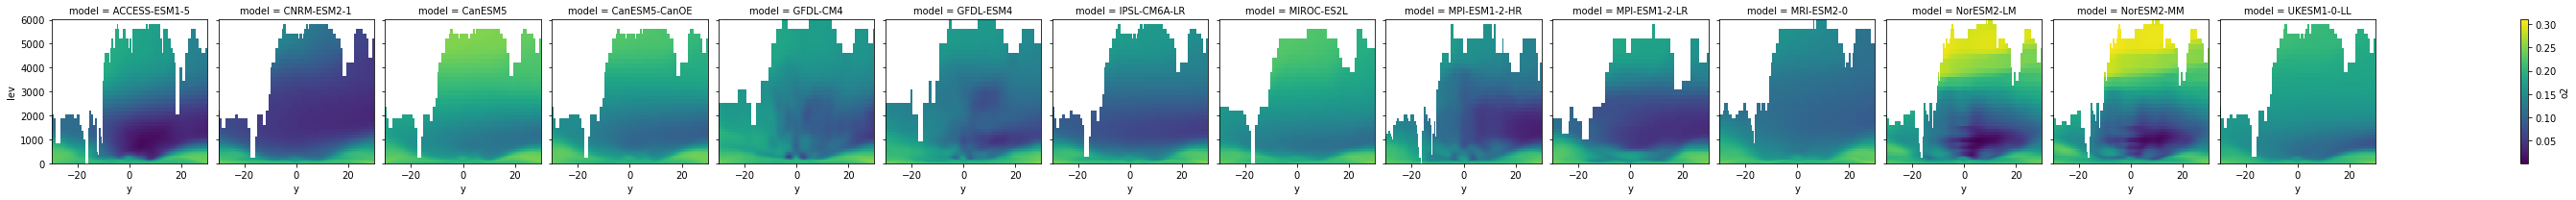

In [15]:
pacific_z_reloaded.o2.interp(x=180).plot(col='model')

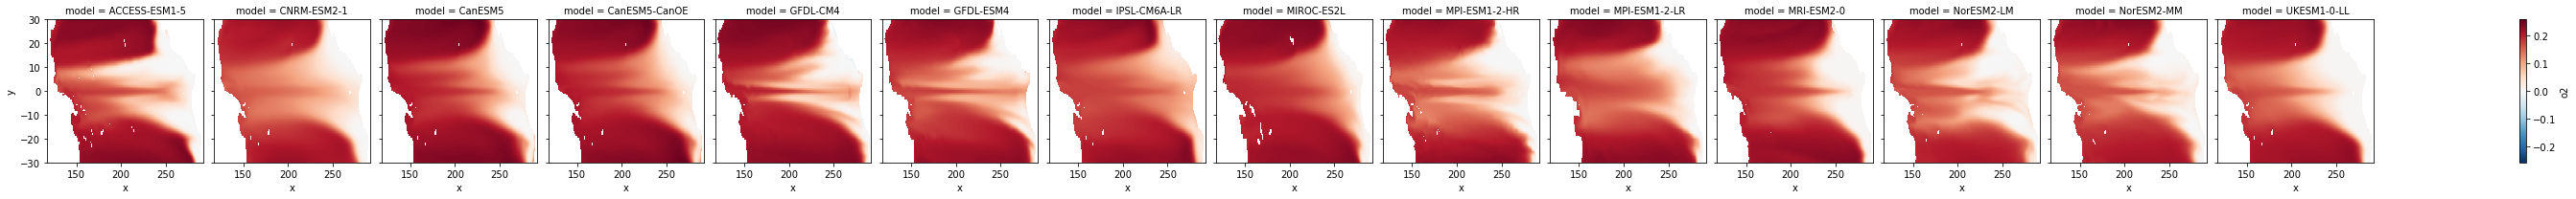

In [16]:
pacific_z_reloaded.o2.interp(lev=200).plot(col='model')